Filtering Data with price, sqft living, grade

In [86]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [87]:
# Reading our csv file as dataframe
df = pd.read_csv('data/kc_house_data.csv')



In [88]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,17755.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000
mean,4580474287.77099,540296.57351,3.37320,2.11583,2080.32185,15099.40876,1.49410,1788.59684,1970.99968,83.63678,98077.95185,47.56009,-122.21398,1986.62032,12758.28351
std,2876735715.74778,367368.14010,0.92630,0.76898,918.10613,41412.63688,0.53968,827.75976,29.37523,399.94641,53.51307,0.13855,0.14072,685.23047,27274.44195
min,1000102.00000,78000.00000,1.00000,0.50000,370.00000,520.00000,1.00000,370.00000,1900.00000,0.00000,98001.00000,47.15590,-122.51900,399.00000,651.00000
25%,2123049175.00000,322000.00000,3.00000,1.75000,1430.00000,5040.00000,1.00000,1190.00000,1951.00000,0.00000,98033.00000,47.47110,-122.32800,1490.00000,5100.00000
50%,3904930410.00000,450000.00000,3.00000,2.25000,1910.00000,7618.00000,1.50000,1560.00000,1975.00000,0.00000,98065.00000,47.57180,-122.23100,1840.00000,7620.00000
75%,7308900490.00000,645000.00000,4.00000,2.50000,2550.00000,10685.00000,2.00000,2210.00000,1997.00000,0.00000,98118.00000,47.67800,-122.12500,2360.00000,10083.00000
max,9900000190.00000,7700000.00000,33.00000,8.00000,13540.00000,1651359.00000,3.50000,9410.00000,2015.00000,2015.00000,98199.00000,47.77760,-121.31500,6210.00000,871200.00000


In [89]:
# Converting grade values to numeric for easy data manipulation.
df['grade'] = df['grade'].str.slice(0,2).str.strip()
df['grade'] = df['grade'].astype(np.int64)

In [90]:
# Dealing missing values in views by converting them to numeric values.
df['view'].fillna('NONE', inplace=True)
df['view'].replace('NONE', '0', inplace=True)
df['view'].replace('FAIR', '1', inplace=True)
df['view'].replace('AVERAGE', '2', inplace=True)
df['view'].replace('GOOD', '3', inplace=True)
df['view'].replace('EXCELLENT', '4', inplace=True)
df['view'] = df['view'].astype(np.int64)

In [91]:
# Converting yr_renovated values to numeric int for easy data manipulation.
# 0 means the house is not renovated and 1 means the house is renovated.
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['is_rennovated'] = df['yr_renovated'].map(lambda x: 1 if x > 0 else 0)
df['is_rennovated'].value_counts()
df = df.drop(['yr_renovated'], axis=1)
df.is_rennovated.value_counts()

0    20853
1      744
Name: is_rennovated, dtype: int64

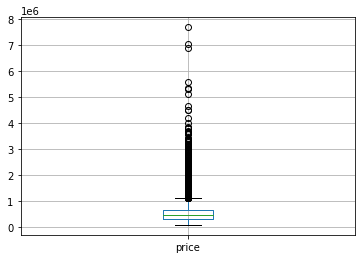

In [92]:
boxplot_price = df.boxplot(column = "price")
#Box Plot of the whole Price column

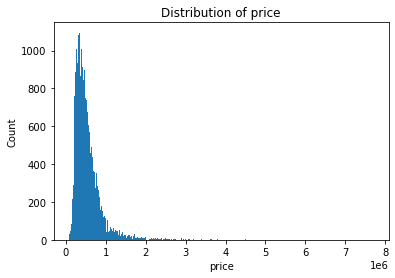

In [93]:
fig, ax = plt.subplots()
ax.hist(df["price"], bins="auto")
ax.set_xlabel("price")
ax.set_ylabel("Count")
ax.set_title("Distribution of price");
#Histogram of the whole Price Column

In [94]:
luxury_homes = df.loc[df['price'] >= 645000] #Using the Q3 statistic (645,000)
luxury_homes #When I used an arbitrary price 1,000,000, not enough data samples, only 1490 total houses. Jelly requires 5,000 samples. 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,is_rennovated
5,7237550310,5/12/2014,1230000.00000,4,4.50000,5420,101930,1.00000,NO,0,...,11,3890,1530.0,2001,98053,47.65610,-122.00500,4760,101930,0
10,1736800520,4/3/2015,662500.00000,3,2.50000,3560,9796,1.00000,NaN,0,...,8,1860,1700.0,1965,98007,47.60070,-122.14500,2210,8925,0
15,9297300055,1/24/2015,650000.00000,4,3.00000,2950,5000,2.00000,NO,3,...,9,1980,970.0,1979,98126,47.57140,-122.37500,2140,4000,0
21,2524049179,8/26/2014,2000000.00000,3,2.75000,3050,44867,1.00000,NO,4,...,9,2330,720.0,1968,98040,47.53160,-122.23300,4110,20336,0
26,1794500383,6/26/2014,937000.00000,3,1.75000,2450,2691,2.00000,NO,0,...,8,1750,700.0,1915,98119,47.63860,-122.36000,1760,3573,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21580,7502800100,8/13/2014,679950.00000,5,2.75000,3600,9437,2.00000,NO,0,...,9,3600,0.0,2014,98059,47.48220,-122.13100,3550,9421,0
21581,191100405,4/21/2015,1580000.00000,4,3.25000,3410,10125,2.00000,NO,0,...,10,3410,?,2007,98040,47.56530,-122.22300,2290,10125,0
21583,7202300110,9/15/2014,810000.00000,4,3.00000,3990,7838,2.00000,NO,0,...,9,3990,0.0,2003,98053,47.68570,-122.04600,3370,6814,0
21584,249000205,10/15/2014,1540000.00000,5,3.75000,4470,8088,2.00000,NO,0,...,11,4470,0.0,2008,98004,47.63210,-122.20000,2780,8964,0


In [95]:
#There are 5411 homes with the price over or equal to the Q3 statistic (75th percentile). 

In [96]:
luxury_homes['price']

5       1230000.00000
10       662500.00000
15       650000.00000
21      2000000.00000
26       937000.00000
             ...     
21580    679950.00000
21581   1580000.00000
21583    810000.00000
21584   1540000.00000
21590   1010000.00000
Name: price, Length: 5411, dtype: float64

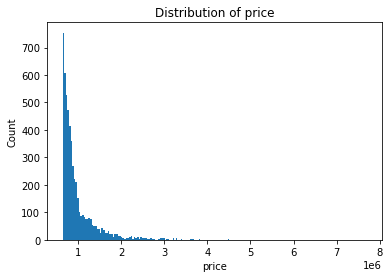

In [97]:
fig, ax = plt.subplots()
ax.hist(luxury_homes['price'], bins="auto")
ax.set_xlabel("price")
ax.set_ylabel("Count")
ax.set_title("Distribution of price");
#histogram of luxy home prices

In [98]:
#Now, filtering the Updated csv data that Julian found. Seeing if this data set is better for our project or not. 


In [99]:
df2 = pd.read_csv('data/kc_house_data_updated.csv')

In [100]:
df2.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000
mean,4538103795.02689,1108535.83787,3.41353,2.33474,2112.42474,16723.59592,1.54349,1809.82610,476.03940,330.21114,217.41204,1975.16395,90.92230,47.32808,-121.31740
std,2882587298.12350,896385.65919,0.98161,0.88956,974.04432,60382.60402,0.56772,878.30613,579.63130,285.77054,245.30279,32.06736,416.47304,1.43400,5.72548
min,1000055.00000,27360.00000,0.00000,0.00000,3.00000,402.00000,1.00000,2.00000,0.00000,0.00000,0.00000,1900.00000,0.00000,21.27424,-157.79148
25%,2064175145.00000,648000.00000,3.00000,2.00000,1420.00000,4850.00000,1.00000,1180.00000,0.00000,0.00000,40.00000,1953.00000,0.00000,47.40532,-122.32604
50%,3874010800.00000,860000.00000,3.00000,2.50000,1920.00000,7480.00000,1.50000,1560.00000,0.00000,400.00000,150.00000,1977.00000,0.00000,47.55138,-122.22558
75%,7287100141.00000,1300000.00000,4.00000,3.00000,2619.50000,10579.00000,2.00000,2270.00000,940.00000,510.00000,320.00000,2003.00000,0.00000,47.66991,-122.11621
max,9904000012.00000,30750000.00000,13.00000,10.50000,15360.00000,3253932.00000,4.00000,12660.00000,8020.00000,3580.00000,4370.00000,2022.00000,2022.00000,64.82407,-70.07434


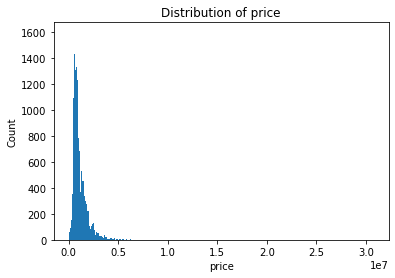

In [101]:
fig, ax = plt.subplots()
ax.hist(df2["price"], bins="auto")
ax.set_xlabel("price")
ax.set_ylabel("Count")
ax.set_title("Distribution of price");
#Histogram of the whole Price Column for df2.

In [102]:
df2_luxury_homes= df.loc[df['price'] >= 650000]
df2_luxury_homes

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,is_rennovated
5,7237550310,5/12/2014,1230000.00000,4,4.50000,5420,101930,1.00000,NO,0,...,11,3890,1530.0,2001,98053,47.65610,-122.00500,4760,101930,0
10,1736800520,4/3/2015,662500.00000,3,2.50000,3560,9796,1.00000,NaN,0,...,8,1860,1700.0,1965,98007,47.60070,-122.14500,2210,8925,0
15,9297300055,1/24/2015,650000.00000,4,3.00000,2950,5000,2.00000,NO,3,...,9,1980,970.0,1979,98126,47.57140,-122.37500,2140,4000,0
21,2524049179,8/26/2014,2000000.00000,3,2.75000,3050,44867,1.00000,NO,4,...,9,2330,720.0,1968,98040,47.53160,-122.23300,4110,20336,0
26,1794500383,6/26/2014,937000.00000,3,1.75000,2450,2691,2.00000,NO,0,...,8,1750,700.0,1915,98119,47.63860,-122.36000,1760,3573,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21580,7502800100,8/13/2014,679950.00000,5,2.75000,3600,9437,2.00000,NO,0,...,9,3600,0.0,2014,98059,47.48220,-122.13100,3550,9421,0
21581,191100405,4/21/2015,1580000.00000,4,3.25000,3410,10125,2.00000,NO,0,...,10,3410,?,2007,98040,47.56530,-122.22300,2290,10125,0
21583,7202300110,9/15/2014,810000.00000,4,3.00000,3990,7838,2.00000,NO,0,...,9,3990,0.0,2003,98053,47.68570,-122.04600,3370,6814,0
21584,249000205,10/15/2014,1540000.00000,5,3.75000,4470,8088,2.00000,NO,0,...,11,4470,0.0,2008,98004,47.63210,-122.20000,2780,8964,0


In [103]:
#Comparing the price filtering results of df and df2, 
#there is no significant difference for us because both threshold prices for us to get 5,000 samples is $650,000.

We have decided to use the original data set.

In [104]:
#Further filtering df to remove the outliers. 
#I will use the z-score method with alpha = .05 and confidence level of 95%. 
#We will be keeping the outliers because the data was entered correctly and the outliers will help with our modeling. 
luxury_homes.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,is_rennovated
count,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000,5411.00000
mean,4509829590.58972,985305.04824,3.82074,2.67224,2994.35834,21347.98207,1.71207,0.61985,8.83792,2530.26853,1972.83792,98073.68047,47.61955,-122.20282,2615.40917,16272.32951,0.06524
std,2937464865.10189,476253.60598,0.89299,0.78868,1025.93197,60349.67380,0.49683,1.19170,1.22413,982.90140,32.53985,51.29071,0.07525,0.13583,781.38220,35208.90151,0.24697
min,1200019.00000,645000.00000,1.00000,0.75000,890.00000,520.00000,1.00000,0.00000,5.00000,580.00000,1900.00000,98001.00000,47.15930,-122.51400,860.00000,967.00000,0.00000
25%,1938500075.00000,720000.00000,3.00000,2.25000,2320.00000,5400.00000,1.00000,0.00000,8.00000,1750.00000,1951.00000,98033.00000,47.57080,-122.31400,2010.00000,5250.00000,0.00000
50%,3885803895.00000,825000.00000,4.00000,2.50000,2880.00000,8580.00000,2.00000,0.00000,9.00000,2430.00000,1981.00000,98074.00000,47.62980,-122.20900,2570.00000,8413.00000,0.00000
75%,7308600025.00000,1050000.00000,4.00000,3.25000,3500.00000,14347.50000,2.00000,0.00000,10.00000,3150.00000,2001.00000,98115.00000,47.67320,-122.10450,3130.00000,12931.00000,0.00000
max,9839301165.00000,7700000.00000,10.00000,8.00000,13540.00000,1651359.00000,3.50000,4.00000,13.00000,9410.00000,2015.00000,98199.00000,47.77640,-121.69100,6210.00000,871200.00000,1.00000


In [105]:
data = luxury_homes['price']
stats.norm.interval(alpha=0.95, loc=np.mean(data), scale=stats.sem(data))

(972615.4579211454, 997994.638549008)

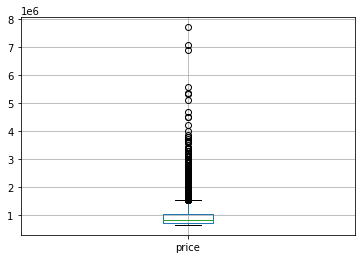

In [106]:
boxplot_price = luxury_homes.boxplot(column = "price")

In [107]:
#First Linear Regression Model 
#using bedrooms

data = luxury_homes
X= luxury_homes.drop('price', axis =1)
y = luxury_homes['price']

In [108]:
formula = 'price ~ bedrooms'
sqft_lot_mod = ols(formula = formula, data = data).fit()

In [109]:
sqft_lot_mod_summ = sqft_lot_mod.summary()
sqft_lot_mod_summ


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     234.1
Date:                Thu, 15 Sep 2022   Prob (F-statistic):           9.13e-52
Time:                        18:09:21   Log-Likelihood:                -78305.
No. Observations:                5411   AIC:                         1.566e+05
Df Residuals:                    5409   BIC:                         1.566e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.703e+05   2.79e+04     20.472      0.000    5.16e+05    6.25e+05
bedrooms    1.086e+05   7099.576     15.300      0.000    9.47e+04    1.23e+05
==============================================================================
Omnibus:                     4611.373   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           185686.061
Skew:                           3.897   Prob(JB):                         0.00
Kurtosis:                      30.619   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
#Second Linear Regression Model 
#using grade, views, bathrooms

data = luxury_homes
X= luxury_homes.drop('price', axis =1)
y = luxury_homes['price']

In [118]:
formula = 'price ~ grade + view + bathrooms'
grade_view_bath_mod = ols(formula = formula, data = data).fit()

In [119]:
grade_view_bath_summ = grade_view_bath_mod.summary()
grade_view_bath_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     1054.
Date:                Thu, 15 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:24:10   Log-Likelihood:                -77174.
No. Observations:                5411   AIC:                         1.544e+05
Df Residuals:                    5407   BIC:                         1.544e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.172e+05   3.79e+04    -16.282      0.000   -6.92e+05   -5.43e+05
grade       1.302e+05   5189.528     25.089      0.000     1.2e+05     1.4e+05
view        1.045e+05   4359.965     23.974      0.000     9.6e+04    1.13e+05
bathrooms   1.448e+05   8041.350     18.010      0.000    1.29e+05    1.61e+05
==============================================================================
Omnibus:                     4128.251   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           163491.213
Skew:                           3.268   Prob(JB):                         0.00
Kurtosis:                      29.124   Cond. No.                         69.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
#Creating Visualizations

<ipython-input-111-02b7dca4f403>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(labels = ylabels)


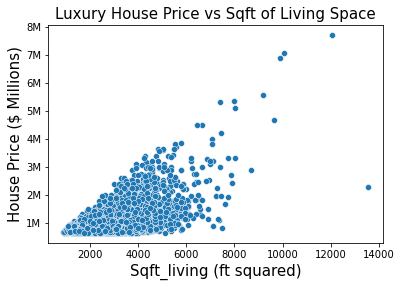

In [111]:
#Scatter plot of House Price vs Sqft of Living Space of Luxury Homes in King County
g=sns.scatterplot(data=data, x="sqft_living", y="price")

ylabels = ['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M']
g.set_yticklabels(labels = ylabels)
plt.xlabel('Sqft_living (ft squared)', size = 15)
plt.ylabel('House Price ($ Millions)', size = 15)
plt.title('Luxury House Price vs Sqft of Living Space', size = 15)


plt.show()

<ipython-input-112-27b760a99d83>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(labels = ylabels)


Text(0.5, 1.0, 'Luxury House Price vs House Condition')

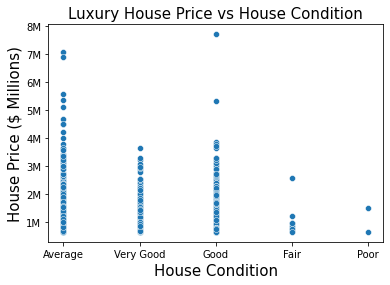

In [112]:
#Scatter plot of Price vs Condition
g = sns.scatterplot(data=data, x="condition", y="price")

ylabels = ['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M']
g.set_yticklabels(labels = ylabels)

plt.xlabel('House Condition', size = 15)
plt.ylabel('House Price ($ Millions)', size = 15)
plt.title('Luxury House Price vs House Condition', size = 15)